# Problème IV : Classification

## 4.1 Analyse des données :

On commence par importer les librairies nécessaires.

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Softmax
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Puis, importons notre base de données.

In [398]:
data= pd.read_csv("HD_Complete_Data.csv", sep=";")
data.head(5)

,Age,Sexe,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Divisons notre base de données en prédicteurs et variable à classifier.

In [399]:
x= data.iloc[:,:-1]
y= data.iloc[:,-1]

Commençons par l'analyse des colonnes non quantitatives.

In [400]:
non_numerical_columns = x.select_dtypes(exclude='number').columns.tolist()
non_numerical_columns

['Sexe', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

On extrait une liste des colonne numériques à analyser plus tard.

In [401]:
numerical_columns = [data.columns[i] for i in range(len(data.columns)) if data.columns[i] not in non_numerical_columns]
numerical_columns = numerical_columns[:-1]
numerical_columns

['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

On essaie d'extraire les valeurs distinctes de chacune de ces variables qualitatives:

In [402]:
for c in non_numerical_columns:
    print(c, " : ", set(data[c]))

Sexe  :  {'F', 'M'}
ChestPainType  :  {'ASY', 'NAP', 'TA', 'ATA'}
RestingECG  :  {'ST', 'LVH', 'Normal'}
ExerciseAngina  :  {'Y', 'N'}
ST_Slope  :  {'Flat', 'Down', 'Up'}


Il s'agit des descriptions qualitatives des caractères qui peuvent être liés à une maladie cardiaque (douleur thoracique...). Désignons lesquelles sont hiérarchiques ou non.

-> Sexe : non hiérarchique.<br>
-> ChestPainType : non hierarchique car quelques instances n'ont aucune relation entre eux.<br>
-> RestingECG : types of resting electrocardiogram (ECG) results, donc hiérarchique.<br>
-> ExerciseAngina : designe si l'individu expérience une angine thoracique, donc on peut la décrire de hiérarchique.<br>
-> ST_Slope : décrit une pente d'une segment de test ECG donc hiérarchique.

Il faut bien noter ici qu'il est nécessaire d'encoder hiérarchiquement (si possible) les variables qualitatives ci dessus car les réseaux de neurones ne prennent en entrée que du numérique. (On peut aussi les encoder avec One Hot Encoding comme mentionné dans le cours)

In [403]:
from sklearn.preprocessing import LabelEncoder

column_name = 'Sexe'
label_encoder = LabelEncoder()

data[column_name + '_encoded'] = label_encoder.fit_transform(data[column_name])

In [404]:
column_name = 'ChestPainType'
label_encoder = LabelEncoder()

data[column_name + '_encoded'] = label_encoder.fit_transform(data[column_name])

In [405]:
column_name = 'RestingECG'
label_encoder = LabelEncoder()

data[column_name + '_encoded'] = label_encoder.fit_transform(data[column_name])

In [406]:
column_name = 'ExerciseAngina'
label_encoder = LabelEncoder()

data[column_name + '_encoded'] = label_encoder.fit_transform(data[column_name])

In [407]:
column_name = 'ST_Slope'
label_encoder = LabelEncoder()

data[column_name + '_encoded'] = label_encoder.fit_transform(data[column_name])

In [408]:
# on supprime les colonnes catégorielles qu'on vient d'encoder
data= data.drop(non_numerical_columns, axis=1)

In [409]:
data.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sexe_encoded,ChestPainType_encoded,RestingECG_encoded,ExerciseAngina_encoded,ST_Slope_encoded
0,40,140,289,0,172,0.0,0,1,1,1,0,2
1,49,160,180,0,156,1.0,1,0,2,1,0,1
2,37,130,283,0,98,0.0,0,1,1,2,0,2
3,48,138,214,0,108,1.5,1,0,0,1,1,1
4,54,150,195,0,122,0.0,0,1,2,1,0,2


Maintenant, intéressons nous aux variables numériques.

In [410]:
numerical_columns

['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

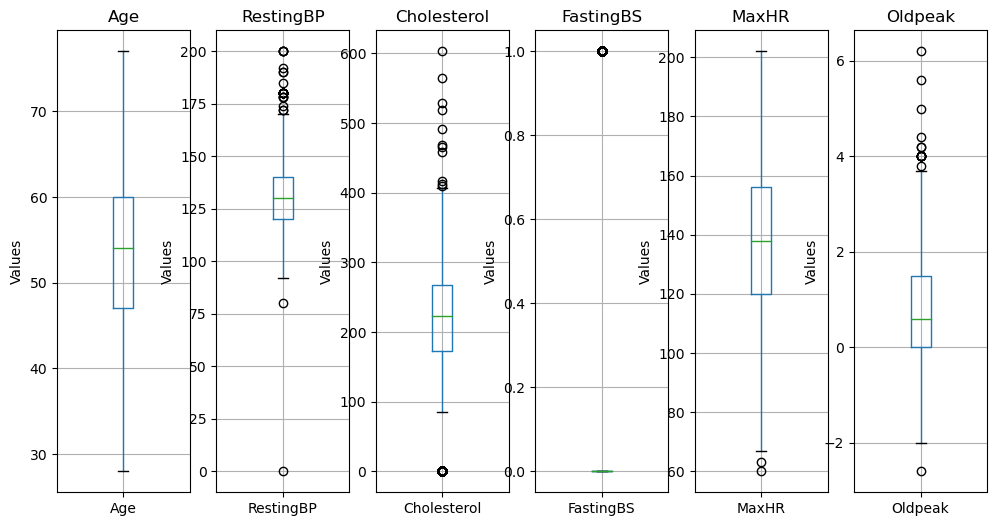

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=len(numerical_columns), figsize=(12, 6))

for i, column_name in enumerate(numerical_columns):
    data.boxplot(column=column_name, ax=axs[i])
    axs[i].set_title(f'{column_name}')
    axs[i].set_ylabel('Values')

plt.show()

On remarque que chacune des variables a son propre échelle, alors ceci renforce l'hypothèse de normalisation des données surtout après l'encodage.

In [16]:
print("nombre de personnes touchés par la maladie :", len(data[data["HeartDisease"]==1]))
print("nombre de personnes non touchés par la maladie :", len(data[data["HeartDisease"]==0]))

nombre de personnes touchés par la maladie : 508
nombre de personnes non touchés par la maladie : 410


Divisons d'abord nos variables en prédicteurs et la variable à classifier (La variable à classifier est dans la 6ième colonne):

In [411]:
y= data.iloc[:,6]
x= data.iloc[:,[i for i in range(len(data.columns)) if i!=6]]
x.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sexe_encoded,ChestPainType_encoded,RestingECG_encoded,ExerciseAngina_encoded,ST_Slope_encoded
0,40,140,289,0,172,0.0,1,1,1,0,2
1,49,160,180,0,156,1.0,0,2,1,0,1
2,37,130,283,0,98,0.0,1,1,2,0,2
3,48,138,214,0,108,1.5,0,0,1,1,1
4,54,150,195,0,122,0.0,1,2,1,0,2


In [412]:
y

0      0
1      1
2      0
3      1
4      0
      ..
913    1
914    1
915    1
916    1
917    0
Name: HeartDisease, Length: 918, dtype: int64

normalisons x.

In [19]:
import sklearn
x=sklearn.preprocessing.normalize(x)
x.shape

(918, 11)

## 4.2 Implémentation du réseau de neurones :

Commençons par une discussion sur les hypèreparamètres à utiliser : notre base de données contient presque 1000 samples, on utilisera un batch size de 100 ce qui correspond à peu près à 10 itérations par epoch. 

Le principe de mise à jour des weights et biais dans les neurals networks se font en back-propagation : à chaque epoch, on calculera une fonction d'erreur (MSE, MAE, ou Hinge Loss), on essaie de mettre à jour nos paramètres de telle façon que cette fonction soit minimisée à l'aide d'optimiseur tel que : la descente de gradient déterministe, la descente de gradient stochastique (1 batch), ou un mini-batch gradient descent.

Computationellement, il est très couteux d'utiliser le gradient déterministe, pour nous contourner à ce problème on utilise le gradient mini-batch ou stochastique, qui donnera des predictions avec du bruit, mais on essaie de combler un tel bruit à l'aide d'optimiseurs tels que ADAM, Momentum gradient descent, Nesterov accelerated gradient descent...

On essayera d'explorer tous ces hypèrparamètres dans la suite.

On essaie de diviser nos données d'une manière aléatoire en 20 % pour le test et le reste pour entrainer notre modèle.

In [413]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

On commence par un modèle directe sans hidden layer.

In [31]:
model = Sequential()
#on utilisera relu puis sigmoid comme fonctions d'activation
#Input Layer
model.add(Dense(x_train.shape[1], activation='relu', input_dim = x_train.shape[1]))
#output layer
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 11)                132       
                                                                 
 dense_3 (Dense)             (None, 1)                 12        
                                                                 
Total params: 144 (576.00 Byte)
Trainable params: 144 (576.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=10,
                    validation_data = (x_test, y_test),
                    verbose=0)

In [ ]:
plt.plot(history.history['mse'])
plt.show()

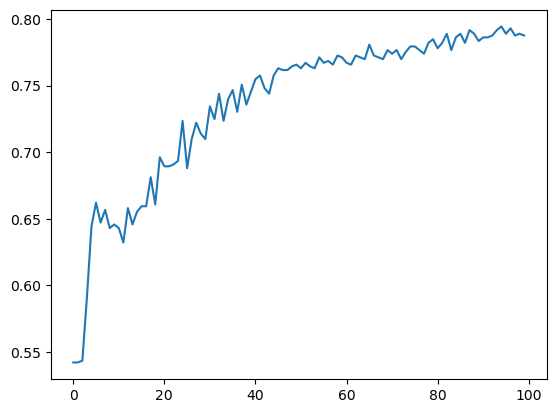

In [34]:
plt.plot(history.history['accuracy'])
plt.show()

On remarque beacoup de bruit dans les erreurs et la precision du modèle avec chaque epoch. Essayons d'augmenter le batchsize en gradant le même nombre d'epoch.

In [25]:
#on change batch_size=200
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=200,
                    validation_data = (x_test, y_test),
                    verbose=0)

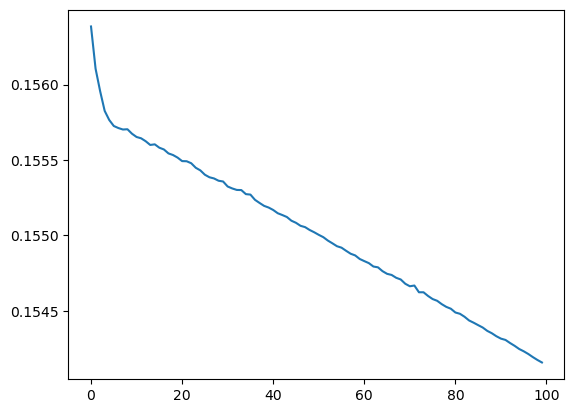

In [26]:
plt.plot(history.history['mse'])
plt.show()

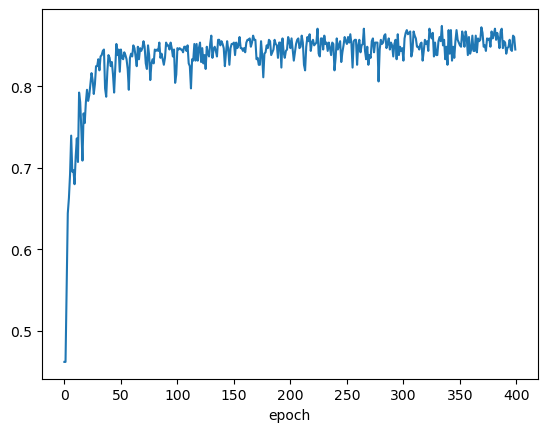

In [56]:
plt.plot(history.history['accuracy'])
plt.show()

On constate qu'avec un nombre élevé de batchsize, on constate que les metrics de performance (accuracy & mse) deviennent moins bruités, bien que les variations de la précision semblent plus aggressives. Ceci est due à l'overfitting, notre modèle avec une plus grande batch size est plus biaisé sur une partie de notre base de données et ne peut pas être géneralisable, c'est pour cela qu'on prefère bien une approche stochastique au problème.

Il faut aussi prendre un nombre de batch size un peu plus significatif pour éviter le bruit (variance). En gros, on prend un batch size qui est l'optimum du trade-off de la variance et le biais.

Trouvons la précision et le mse du modèle avec des hyperparamètres définit par défaut de la part de Keras.

In [28]:
score = model.evaluate(x_test, y_test, verbose=0)
print("accuracy :", score[1])
print("loss :", score[2])

accuracy : 0.820652186870575
loss : 0.15164607763290405


## Tuning des hypèrparamètre :

Maintenant qu'on a tatonné avec le modèle précedent, essayons de l'optimiser de telle façon qu'on maximise la précision de validation (on se concentre juste sur cette métrique).

Avant de nous plonger dans le processus de tuning, ouvrons nous sur les hypèrparamètres à ajuster : les hyperparamètres les plus connues sont le "learning rate" i.e le nombre d'étapes éffectués par l'optimiseur de descente de gradient, les $\beta_1$ et $\beta_2$ pour le momentum et velocity du gradient, le nombre de hidden layers, le nombre d'unités par layer, et puis le batch size. 

à l'aide de cross validation on peut déterminer de telles paramètres optimales: pour cette objective, il en existe deux méthodes: on crée une série de valeurs dans la plage de valeurs associé à chaque paramètres, puis on évalue la performance des modèles créés à partir de chacune de ces valeurs, dans ce stage il existe deux méthodes pour le choix de telles paramètres à chaque itération: il s'agit soit d'une $recherche aléatoire$ ou recherche par grille séquentielle ($grid search$).

Afin de réduire un peu le cout computationelle, on ne s'intéresse qu'aux hyperparamètres les plus importantes: le learning rate, le nombre de layers, puis le nombre d'unités dans chaque layer créée.

In [120]:
import tensorflow as tf
from tensorflow import keras
from kerastuner import HyperParameters
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy

def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(x.shape[1],)))

    # Tuning the number of layers (from 1 to 5 layers)
    hp_layers = hp.Int("num_layers", min_value=1, max_value=5, step=1)
    for i in range(hp_layers):
        # Tuning the units per layer (8 to 64)
        hp_units = hp.Int(f"units_{i}", min_value=8, max_value=64, step=4)
        model.add(keras.layers.Dense(units=hp_units, activation="relu"))

    # Add output layer for binary classification
    model.add(keras.layers.Dense(1, activation="sigmoid"))  # Sigmoid for binary classification

    # Tuning the learning rate for the optimizer
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=BinaryCrossentropy(),
                  metrics=[BinaryAccuracy(threshold=0.5)])  # Using BinaryAccuracy for binary classification

    return model


In [121]:
from kerastuner.tuners import Hyperband
import kerastuner as kt
from kerastuner import HyperParameters
tuner= kt.Hyperband(model_builder,
                   objective= "val_accuracy",
                   max_epochs=10,
                   factor=3,
                   directory="my_dir",
                   project_name="tuuner")

Reloading Tuner from my_dir\tuuner\tuner0.json


In [122]:
stop_early= tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

In [123]:
tuner.search(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[stop_early])

In [124]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
our_model= tuner.hypermodel.build(best_hps)
our_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 52)                624       
                                                                 
 dense_64 (Dense)            (None, 32)                1696      
                                                                 
 dense_65 (Dense)            (None, 52)                1716      
                                                                 
 dense_66 (Dense)            (None, 24)                1272      
                                                                 
 dense_67 (Dense)            (None, 8)                 200       
                                                                 
 dense_68 (Dense)            (None, 1)                 9         
                                                                 
Total params: 5517 (21.55 KB)
Trainable params: 5517 

In [125]:
history= our_model.fit(x_train, y_train, epochs=400, validation_split=0.2, verbose=0)

In [126]:
#on choisit le nb d'epochs maximisant l'accuracy de validation
prec_par_epoch = history.history['val_binary_accuracy']
epoch_opt = prec_par_epoch.index(max(prec_par_epoch)) 
print("meilleur epoch :", epoch_opt)

meilleur epoch : 345


In [127]:
model_best = tuner.hypermodel.build(best_hps)
model_best.fit(x_train, y_train, epochs=epoch_opt, validation_split=0.2,verbose=0)

In [133]:
score = model_best.evaluate(x_test, y_test, verbose=0)
print('Test accuracy :', score[1])

Test accuracy : 0.8695651888847351


On a obtenu une précision de modèle 87 $\%$, supérieur au précedent.

Mesurons maintenant les autres métriques de notre modèle optimale sur les données test.

In [130]:
y_pred = model_best.predict(x_test)

6/6 [==============================] - 0s 4ms/step


In [134]:
y_pred= [1 if pred[0]>0.5 else 0 for pred in y_pred]

In [135]:
y_pred

[1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0]

In [139]:
from sklearn.metrics import precision_score

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

Precision: 0.9056603773584906


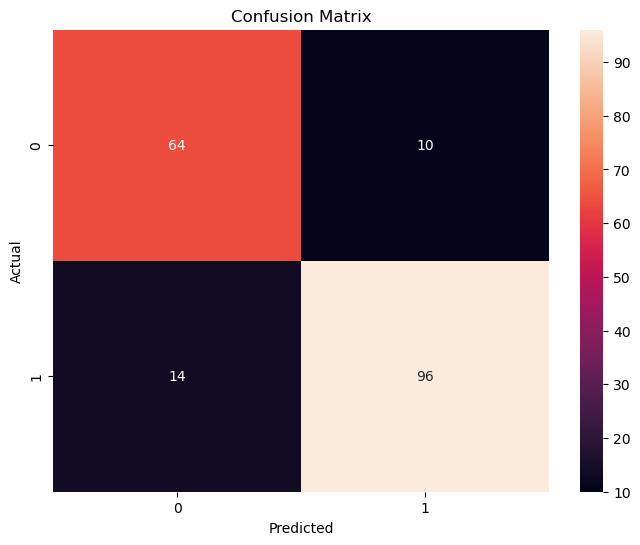

In [145]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


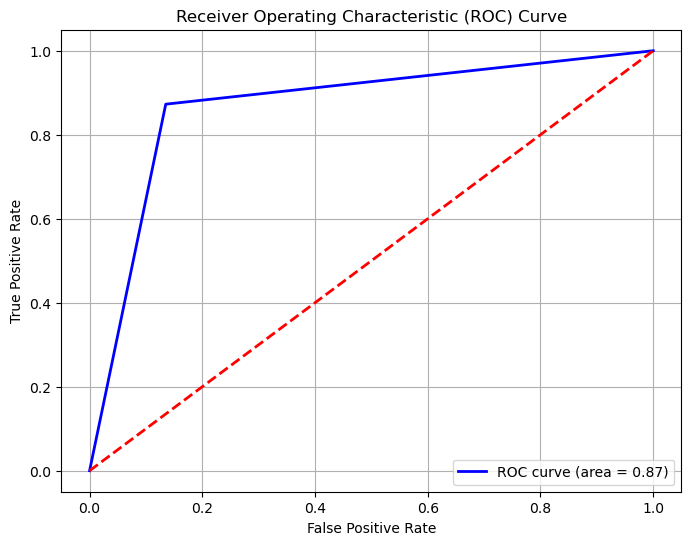

In [146]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [147]:
print("AUC:", roc_auc)

AUC: 0.8687960687960689


In [148]:
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Sensitivity: 0.8727272727272727
Specificity: 0.8648648648648649


Notre modèle a achevé une précision de 90% sur les données test, couplée d'une bonne sensitivité et une bonne sensibilité qui sont approximativement de 87$\%$ les deux. Notre modèle a géneralement eu une performance parfaite sur nos données test.

On essaie de vérifier si ce modèle est géneralisable à notre base de données par 10 fold cross validaiton.

In [149]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
num_folds = 10

accuracies = []
auc_scores = []
sensitivities = []
specificities = []

skf = StratifiedKFold(n_splits=num_folds, shuffle=True)

for train_index, test_index in skf.split(x, y):  
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model_best.fit(x_train, y_train, epochs=epoch_opt, validation_split=0.2, verbose=0)
    y_pred = model_best.predict(x_test)
    acc = accuracy_score(y_test, y_pred.round())
    auc = roc_auc_score(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred.round())
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    accuracies.append(acc)
    auc_scores.append(auc)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

avg_accuracy = np.mean(accuracies)
avg_auc = np.mean(auc_scores)
avg_sensitivity = np.mean(sensitivities)
avg_specificity = np.mean(specificities)
print("Average Accuracy:", avg_accuracy)
print("Average AUC:", avg_auc)
print("Average Sensitivity:", avg_sensitivity)
print("Average Specificity:", avg_specificity)

3/3 [==============================] - 0s 3ms/step
Average Accuracy: 0.8746416626851408
Average AUC: 0.9385451936872309
Average Sensitivity: 0.9115294117647057
Average Specificity: 0.8292682926829269


## Logistic regression

In [414]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

model = LogisticRegression()

model.fit(x_train, y_train)


C:\Users\OH\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [416]:
# Prédiction sur les données de test
y_pred = model.predict(x_test)

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")
print(conf_matrix)

# Calcul de la précision du modèle
precision = precision_score(y_test, y_pred)
print("Précision :", precision)

# Calcul de la sensibilité (recall) du modèle
recall = recall_score(y_test, y_pred)
print("Sensibilité (recall) :", recall)

# Calcul de la spécificité du modèle
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("Spécificité :", specificity)

# Calcul de l'exactitude (accuracy) du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Exactitude (accuracy) :", accuracy)

from sklearn.metrics import roc_auc_score

# Calculating the predicted probabilities for positive class
y_pred_proba = model.predict_proba(x_test)[:, 1]

# Calculating the AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC Score:", auc)

Matrice de confusion :
[[65  9]
 [11 99]]
Précision : 0.9166666666666666
Sensibilité (recall) : 0.9
Spécificité : 0.8783783783783784
Exactitude (accuracy) : 0.8913043478260869
AUC Score: 0.9415233415233415


Etonnement! le modèle de regression est plus performant que les modèles construits précedement.

# Problème V : Analyse d’une série temporelle

Dans la suite on se base sur le modèle LSTM (long terme memory) qui opère d'une manière récurrente sur la base de donnée temporelle pour prédire le future.

In [328]:
#il s'agit d'une base de données mensuelle
data = pd.read_csv('Danube ammonium level Time Series.csv', sep = ';',decimal=',')
data["Months"]=pd.to_datetime(data["Months"], dayfirst = True)
data

,Months,Ammonium
0,1996-01-01,0.253333
1,1996-02-01,0.218889
2,1996-03-01,0.242000
3,1996-04-01,0.134545
4,1996-05-01,0.113333
...,...,...
259,2017-08-01,0.031222
260,2017-09-01,0.045875
261,2017-10-01,0.032474
262,2017-11-01,0.047125


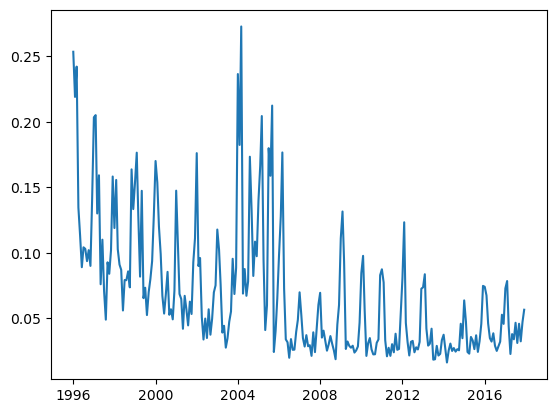

In [186]:
plt.plot(data["Months"], data["Ammonium"])

Normalisons la colonne "Ammonium" pas de façon que les les données soient standardisés mais qu'il soient compris entre 0 et 1 .

In [294]:
import sklearn
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
x= np.array(data["Ammonium"]).reshape(-1, 1)
y = np.array(x[1:][:])
x=np.array(x[:263][:])
x_n = min_max_scaler.fit_transform(x)

On divise nos donnée tel que x représente le taux d'amonium à l'intant t et y à l'instant t+1.

Puisque LSTM prend une array tridimentionnel (batch size, sequence legth, number of features). On essaie de reshape nos données pour les accomoder à une telle structure, on procède avec une approche stochastique (batchsize=1).

In [295]:
x_n = np.reshape(x_n, (x_n.shape[0], 1, x_n.shape[1]))
y = np.reshape(y, (y.shape[0], 1, y.shape[1]))

Enfin, divisons nos données en test et train, tel que x présente les données au temps t et y en t+1.

In [298]:
split=data[data["Months"]=="2016-12-01"].index[0]
x_train, y_train= x_n[:split+1], y[:split+1]
x_test, y_test= x_n[split+1:], y[split+1:]

Créons le modèle, en choisissant des paramètres de notre choix.

Puisqu'on est interessé à l'output directment on utilisera la fonction linear dans le dernier layer, sigmoid est évitée car elle est plus adaptable à la classification binaire.

In [309]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Softmax
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error
model = Sequential()
model.add(LSTM(200, activation='relu',input_shape=(x_train.shape[1],1)))
model.add(Dense(50))
model.add(Dense(1,activation="linear"))
model.compile(loss='mse', optimizer='Adam')
model.fit( x_train, y_train, epochs=100, batch_size=len(train)//10, verbose=0)

In [310]:
y_pred= model.predict(x_test, verbose=0)

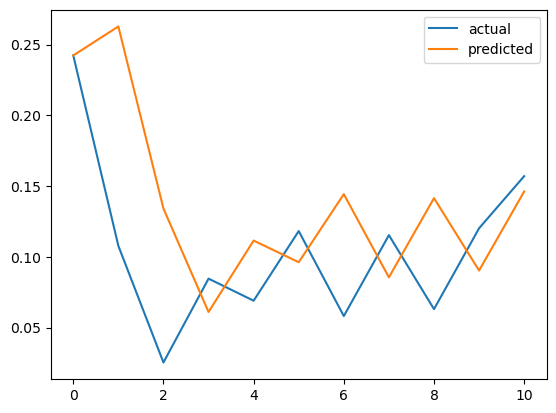

In [317]:
s=y_test.shape[0]
plt.plot(y_test.reshape((s,)), label="actual")
plt.plot(y_pred.reshape((s,)), label="predicted")
plt.legend()
plt.show()

In [314]:
score= model.evaluate(x_test, y_test, verbose=0)
print("rmse :", (score)**0.5)

rmse : 0.07019245974051425


Bien que les 2 courbes ont une monotonie opposée, on a achevé une bonne prédiction de nos données test.

## ARMA/ARIMA model

Il faut bien souligner la stationnarité d'une série pour qu'on lui applique ARIMA/ARMA càd que la moyenne et l'écart type restent constants pour chaque fenêtre prise de la série. 

In [329]:
#we set Months as index for adf test of stationarity
data.set_index('Months', inplace=True)

In [330]:
data.head()

,Ammonium
Months,
1996-01-01,0.253333
1996-02-01,0.218889
1996-03-01,0.242000
1996-04-01,0.134545
1996-05-01,0.113333


In [331]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data)
print('Statistique ADF :', result[0])
print('Valeur critique :', result[4])
print('P-value :', result[1])

Statistique ADF : -1.9198289225041667
Valeur critique : {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}
P-value : 0.3227912219065292


In [333]:
if result[1] < 0.05: #on prend l'erreur standard pour la p-valeur (5%)
    print("La série est stationnaire (rejeter l'hypothèse nulle)")
else:
    print("La série n'est pas stationnaire (ne pas rejeter l'hypothèse nulle)")

La série n'est pas stationnaire (ne pas rejeter l'hypothèse nulle)


On essaie de la differencier y_t= x_t - x_t-1, puis on mesure si elle est stationnaire.

In [334]:
data_diff= data.diff().dropna()

In [335]:
adfuller(data_diff)[1]

1.7660848633660758e-13

La série differenciée est bien stationnaire, essayons de la visualiser.

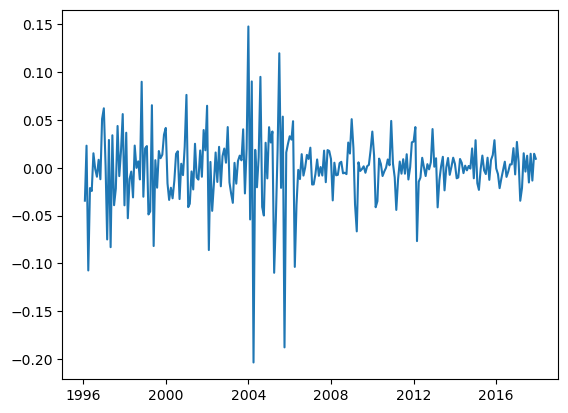

In [336]:
plt.plot(data_diff)

On essaie d'ajuster un modèle ARIMA sur la série differenciée.

In [352]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA 
train = data_diff.iloc[:split+1]
test = data_diff.iloc[split+1:]
model_arima = auto_arima(
    data_diff['Ammonium'],  
    suppress_warnings=True,          #suppress warnings generated 
    stationary=True,                  #treat time series as stationary
)

In [348]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  263
Model:               SARIMAX(4, 0, 3)   Log Likelihood                 542.702
Date:                Thu, 30 Nov 2023   AIC                          -1069.405
Time:                        20:19:24   BIC                          -1040.828
Sample:                    02-01-1996   HQIC                         -1057.920
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1621      0.091     12.717      0.000       0.983       1.341
ar.L2         -0.8852      0.093     -9.488      0.000      -1.068      -0.702
ar.L3          0.0524      0.083      0.634      0.526      -0.110       0.214
ar.L4          0.2113      0.065      3.269      0.001       0.085       0.338
ma.L1         -1.5466      0.082    -18.835      0.000      -1.708      -1.386
ma.L2          1.3728      0.104     13.214      0.000       1.169       1.576
ma.L3         -0.7532      0.071    -10.543      0.000      -0.893      -0.613
sigma2         0.0009   5.43e-05     17.338      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               237.47
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Le modèle optimale est SARIMA(4,0,3).

C:\Users\OH\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\OH\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\OH\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\OH\anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='Months'>

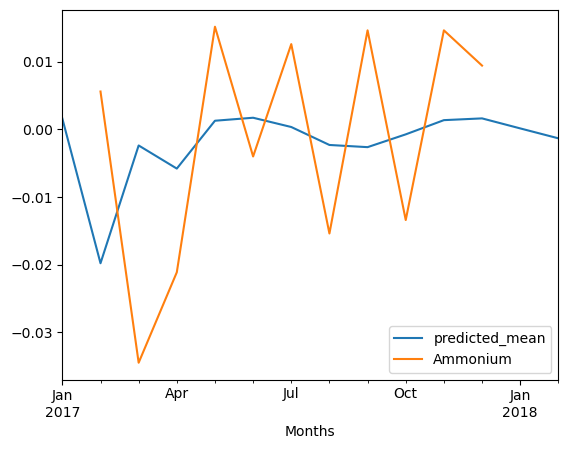

In [373]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_arima = SARIMAX(train["Ammonium"],order=(4,0,3))
fit = model_arima.fit()
pred = fit.predict(start = split, end = len(data), typ = 'levels')
pred.plot(legend = True)
test["Ammonium"].plot(legend = True)

In [381]:
np.sqrt(np.sum(((test["Ammonium"]-pred).dropna())**2))

0.056179965151220965

l'erreur obtenu est inférieure à celle obtenue avec LSTM.

Le modèle ARIMA a été plus performant.

## Modèle fine-tuned

On essaie de tuner nos hyperparamètres en utilisant l'optimisation bayesienne.

In [384]:
data = pd.read_csv('Danube ammonium level Time Series.csv', sep = ';',decimal=',')
data["Months"]=pd.to_datetime(data["Months"], dayfirst = True)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Softmax
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error

In [385]:
import sklearn
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
x= np.array(data["Ammonium"]).reshape(-1, 1)
y = np.array(x[1:][:])
x=np.array(x[:263][:])
x_n = min_max_scaler.fit_transform(x)
split=data[data["Months"]=="2016-12-01"].index[0]
x_train, y_train= x_n[:split+1], y[:split+1]
x_test, y_test= x_n[split+1:], y[split+1:]

In [386]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from kerastuner.tuners import BayesianOptimization

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=500, step=50), 
                   activation='relu', input_shape=(x_train.shape[1], 1)))
    
    for i in range(hp.Int('num_layers', 1, 3)): 
        model.add(Dense(units=hp.Int(f'layer_{i}_units', min_value=10, max_value=100, step=10), 
                        activation='relu'))

    model.add(Dense(1, activation='linear'))

    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(
        learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])))
    
    return model

tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10,  
    executions_per_trial=2,  
    directory='my_dir',  
    project_name='lstm_hyperparam_tuning'
)

tuner.search(x_train, y_train, epochs=100, batch_size=len(train)//10, validation_split=0.2, verbose=0)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model = tuner.hypermodel.build(best_hps)


In [387]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 500)               1004000   
                                                                 
 dense_4 (Dense)             (None, 50)                25050     
                                                                 
 dense_5 (Dense)             (None, 10)                510       
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1029571 (3.93 MB)
Trainable params: 1029571 (3.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [388]:
history= best_model.fit(x_train, y_train, epochs=400, validation_split=0.2, verbose=0)

In [392]:
prec_par_epoch = history.history['val_loss']
epoch_opt = prec_par_epoch.index(min(prec_par_epoch)) 
print("meilleur epoch :", epoch_opt)

meilleur epoch : 31


In [393]:
model_best = tuner.hypermodel.build(best_hps)
model_best.fit(x_train, y_train, epochs=epoch_opt, validation_split=0.2,verbose=0)

In [394]:
y_pred = model_best.predict(x_test)

1/1 [==============================] - 0s 247ms/step


In [397]:
np.sqrt(np.sum((y_pred-y_test)**2))

0.06093491300777041

On a bien obtenu un mse inférieur au modèle initiale, mais l'ARIMA reste insurmontable.

# Conclusion :

- Notons que dans le dernier modèle, on a utlisé l'optimisateur bayesian à la place de grid search utlisé précédemment dans le modèle tuned en problème 4, en notant que cette méthode (bayesienne) effectue la recherche dans la grille des hyperparamètres d'une manière probabiliste. En résumé, Keras Tuner est une bibliothèque plus large qui offre différentes méthodes de recherche d'hyperparamètres, y compris l'optimisation bayésienne, tandis que l'optimisation bayésienne est une technique spécifique qui peut être utilisée pour optimiser les hyperparamètres de divers modèles d'apprentissage automatique. Utilisées ensemble, elles permettent d'effectuer une recherche d'hyperparamètres plus efficace pour les modèles Keras.4

- Il faut aussi ajouter qu'on a fine tune que le learning rate des optimisateurs, le nombre de couches intérmédiaires, et le nombre des unités par chaque couche. Pour aller au dessus, on peut aussi optimiser les $\beta_1$ et $\beta_2$ dans l'optimisateur Adam, et aussi le $\epsilon$ utilisé pour eviter les zeros dans le dénominateur, mais cela reste assez spécifique et demandera des CPUs et GPUs plus puissants.